## Importation

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import glob
import scanpy as sc 

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# local imports
source_path = os.path.abspath("../utilities/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import matrix as matrix
import centrality as central
import curvature as curv

## Load Data

In [4]:
%%time 
resolution = 100000
chrom = "chr7"

dpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/pipeline_outputs/higher_order/by_chromosome/"

file_list = sorted(glob.glob(f"{dpath}population*_{resolution}_{chrom}*"))
fpath = file_list[0]

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
adata

Memory usage: current 2.28 GB, difference +1.74 GB
CPU times: user 790 ms, sys: 149 ms, total: 939 ms
Wall time: 4.95 s


AnnData object with n_obs × n_vars = 1419 × 100067
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'PolII', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

## There's been an Incident!

In [5]:
%%time
H = adata.to_df().copy()
H = H.T.drop_duplicates().T
print(f"raw: {H.shape=}")

# # remove outlier bins (promiscuous )
# s = H.select_dtypes('number').sum(axis=1)
# q1, q3 = s.quantile([0.25, 0.75]); iqr = q3 - q1
# keep = s.between(q1 - 1.5*iqr, q3 + 1.5*iqr)
# H = H[keep]

# now drop newly created singletons
H = H.loc[:, H.sum(0) >= 2]

# drop disgusting hyperedges
H = H.loc[:, H.sum(0) <= 10]

print(f"filtered: {H.shape=}")

H.head()

raw: H.shape=(1419, 87482)
filtered: H.shape=(1419, 87215)
CPU times: user 11.8 s, sys: 3.75 s, total: 15.6 s
Wall time: 15.6 s


read_name  9052b9ea-478f-4351-bc31-6a0a3f9becb5  \
bin_name                                          
chr7:30                                       0   
chr7:31                                       0   
chr7:32                                       0   
chr7:33                                       0   
chr7:34                                       0   

read_name  a7d58484-4b6f-4498-960b-71d8229b3d94  \
bin_name                                          
chr7:30                                       0   
chr7:31                                       0   
chr7:32                                       0   
chr7:33                                       0   
chr7:34                                       0   

read_name  d069851e-2ad6-4ac4-9df1-6a09921b3b7e  \
bin_name                                          
chr7:30                                       0   
chr7:31                                       0   
chr7:32                                       0   
chr7:33                                       0   
chr7:34                                       0   

read_name  ca19a9ca-93bd-4c37-863e-7ec6768a12aa  \
bin_name                                          
chr7:30                                       0   
chr7:31                                       0   
chr7:32                                       0   
chr7:33                                       0   
chr7:34                                       0   

read_name  7bd11f1d-e455-43ff-8f2a-885d6caa5783  \
bin_name                                          
chr7:30                                       0   
chr7:31                                       0   
chr7:32                                       0   
chr7:33                                       0   
chr7:34                                       1   

read_name  fc1788be-74e9-4875-9564-dc0d34afffec  \
bin_name                                          
chr7:30                                       0   
chr7:31                                       0   
chr7:32                                       0   
chr7:33                                       0   
chr7:34                                       0   

read_name  61aae67a-6ec0-43f0-8355-f4e1f9ff7726  \
bin_name                                          
chr7:30                                       0   
chr7:31                                       0   
chr7:32                                       0   
chr7:33                                       0   
chr7:34                                       0   

read_name  176869ef-a2fd-4053-a8bf-a9743f494c6b  \
bin_name                                          
chr7:30                                       0   
chr7:31                                       0   
chr7:32                                       0   
chr7:33                                       0   
chr7:34                                       0   

read_name  9d92ade2-0ef0-419e-9d38-9d2e46340516  \
bin_name                                          
chr7:30                                       0   
chr7:31                                       0   
chr7:32                                       0   
chr7:33                                       0   
chr7:34                                       0   

read_name  fd4e04c2-834f-44b4-8390-f4ff34ca4a95  ...  \
bin_name                                         ...   
chr7:30                                       0  ...   
chr7:31                                       0  ...   
chr7:32                                       0  ...   
chr7:33                                       0  ...   
chr7:34                                       0  ...   

read_name  beae2638-6aff-47f9-b87a-96b56c0fd0fa  \
bin_name                                          
chr7:30                                       0   
chr7:31                                       0   
chr7:32                                       0   
chr7:33                                       0   
chr7:34                                       0   

read_name  10d564ae-1294-48

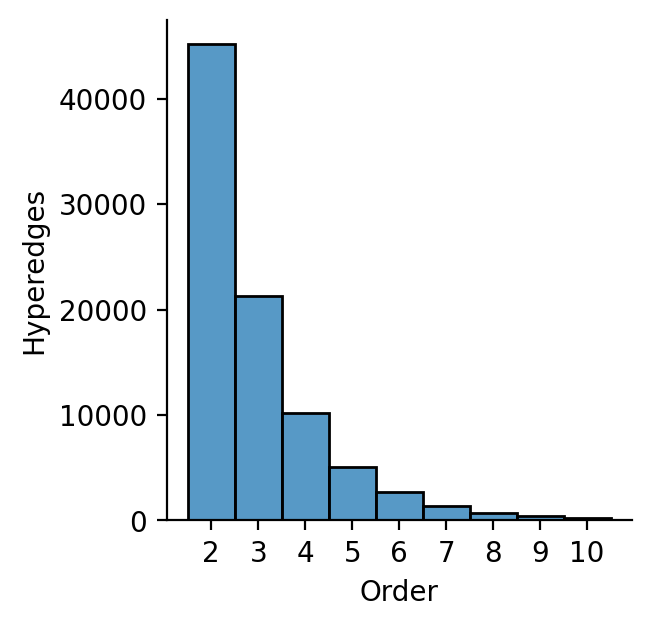

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3.25

x = H.sum(0)
sns.histplot(x, discrete=True, bins=range(int(x.min()), int(x.max())+2))
plt.xticks(range(int(x.min()), int(x.max())+1))

plt.ylabel('Hyperedges')
plt.xlabel('Order')

sns.despine()

## Centrality (of nodes)

CPU times: user 275 ms, sys: 44.1 ms, total: 319 ms
Wall time: 353 ms


ATACSeq      CTCF   H3K27ac  H3K27me3       RNA     PolII
bin_name                                                            
chr7:30   0.177635  0.064267  0.042503  0.094379  0.600299  0.022108
chr7:31   0.734313  0.599630  0.214824  0.143490  0.141617  0.188932
chr7:32   0.930957  0.864848  0.214824  0.121236  0.632391  0.279482
chr7:33   0.950532  0.877416  0.888979  0.195515  0.855577  0.326911
chr7:34   0.859902  0.672740  0.214824  0.218434  0.123885  0.336512

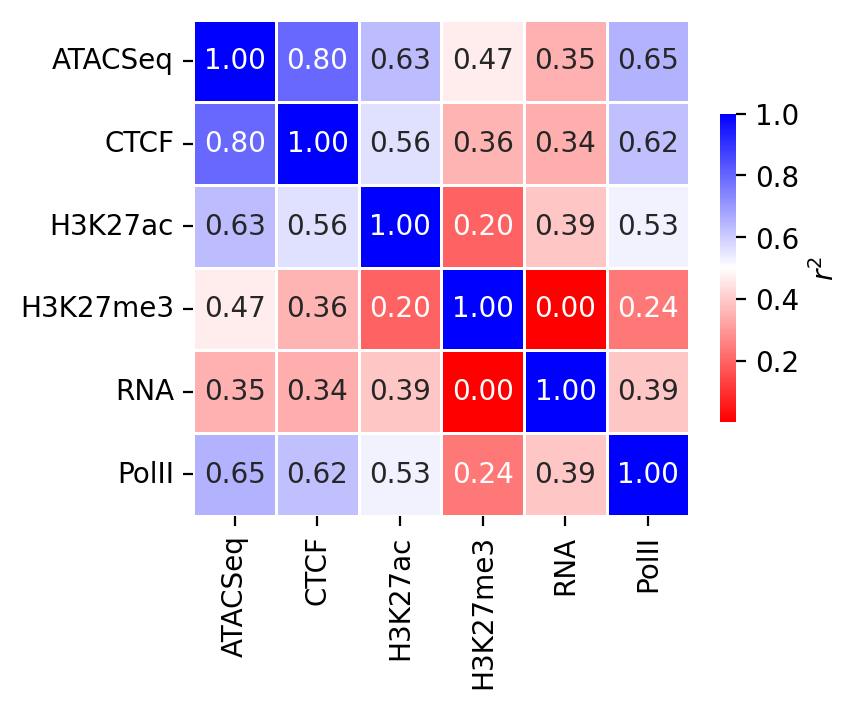

In [7]:
%%time

# set up node features
fields = [
    'ATACSeq_1', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_5', 'PolII',
]

ndf = adata.obs[fields].copy()
ndf.columns = [x.split("_")[0] for x in ndf.columns]
features = ndf.columns

# Step 1: fill NaN with column medians
ndf = ndf.apply(lambda col: col.fillna(col.median()), axis=0)

# Step 2: replace outliers with column median (IQR method)
for col in ndf.columns:
    Q1 = ndf[col].quantile(0.25)
    Q3 = ndf[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    median = ndf[col].median()
    ndf[col] = np.where((ndf[col] < lower) | (ndf[col] > upper), median, ndf[col])


# Step 3: min_max
ndf = ndf.apply(lambda col: ut.min_max(col), axis=0)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
sns.heatmap(
    ndf.corr(),
    square=True,
    cbar_kws={'shrink' : 0.5, 'label' : r'$r^2$'},
    lw=1,
    annot=True,
    fmt=".2f",                     # 2 decimals
    cmap='bwr_r',
)

ndf.head()

In [8]:
ndf.head()

ATACSeq      CTCF   H3K27ac  H3K27me3       RNA     PolII
bin_name                                                            
chr7:30   0.177635  0.064267  0.042503  0.094379  0.600299  0.022108
chr7:31   0.734313  0.599630  0.214824  0.143490  0.141617  0.188932
chr7:32   0.930957  0.864848  0.214824  0.121236  0.632391  0.279482
chr7:33   0.950532  0.877416  0.888979  0.195515  0.855577  0.326911
chr7:34   0.859902  0.672740  0.214824  0.218434  0.123885  0.336512

[INFO] Starting centrality computation for 12 (function × field) runs...
[INFO] Function = lin (linear)
  [1/12] Processing field: ATACSeq -> lin_ATACSeq
  [2/12] Processing field: CTCF -> lin_CTCF
  [3/12] Processing field: H3K27ac -> lin_H3K27ac
  [4/12] Processing field: H3K27me3 -> lin_H3K27me3
  [5/12] Processing field: RNA -> lin_RNA
  [6/12] Processing field: PolII -> lin_PolII
[DONE] All centrality columns added.
CPU times: user 1min 22s, sys: 617 ms, total: 1min 23s
Wall time: 1min 23s


<Axes: >

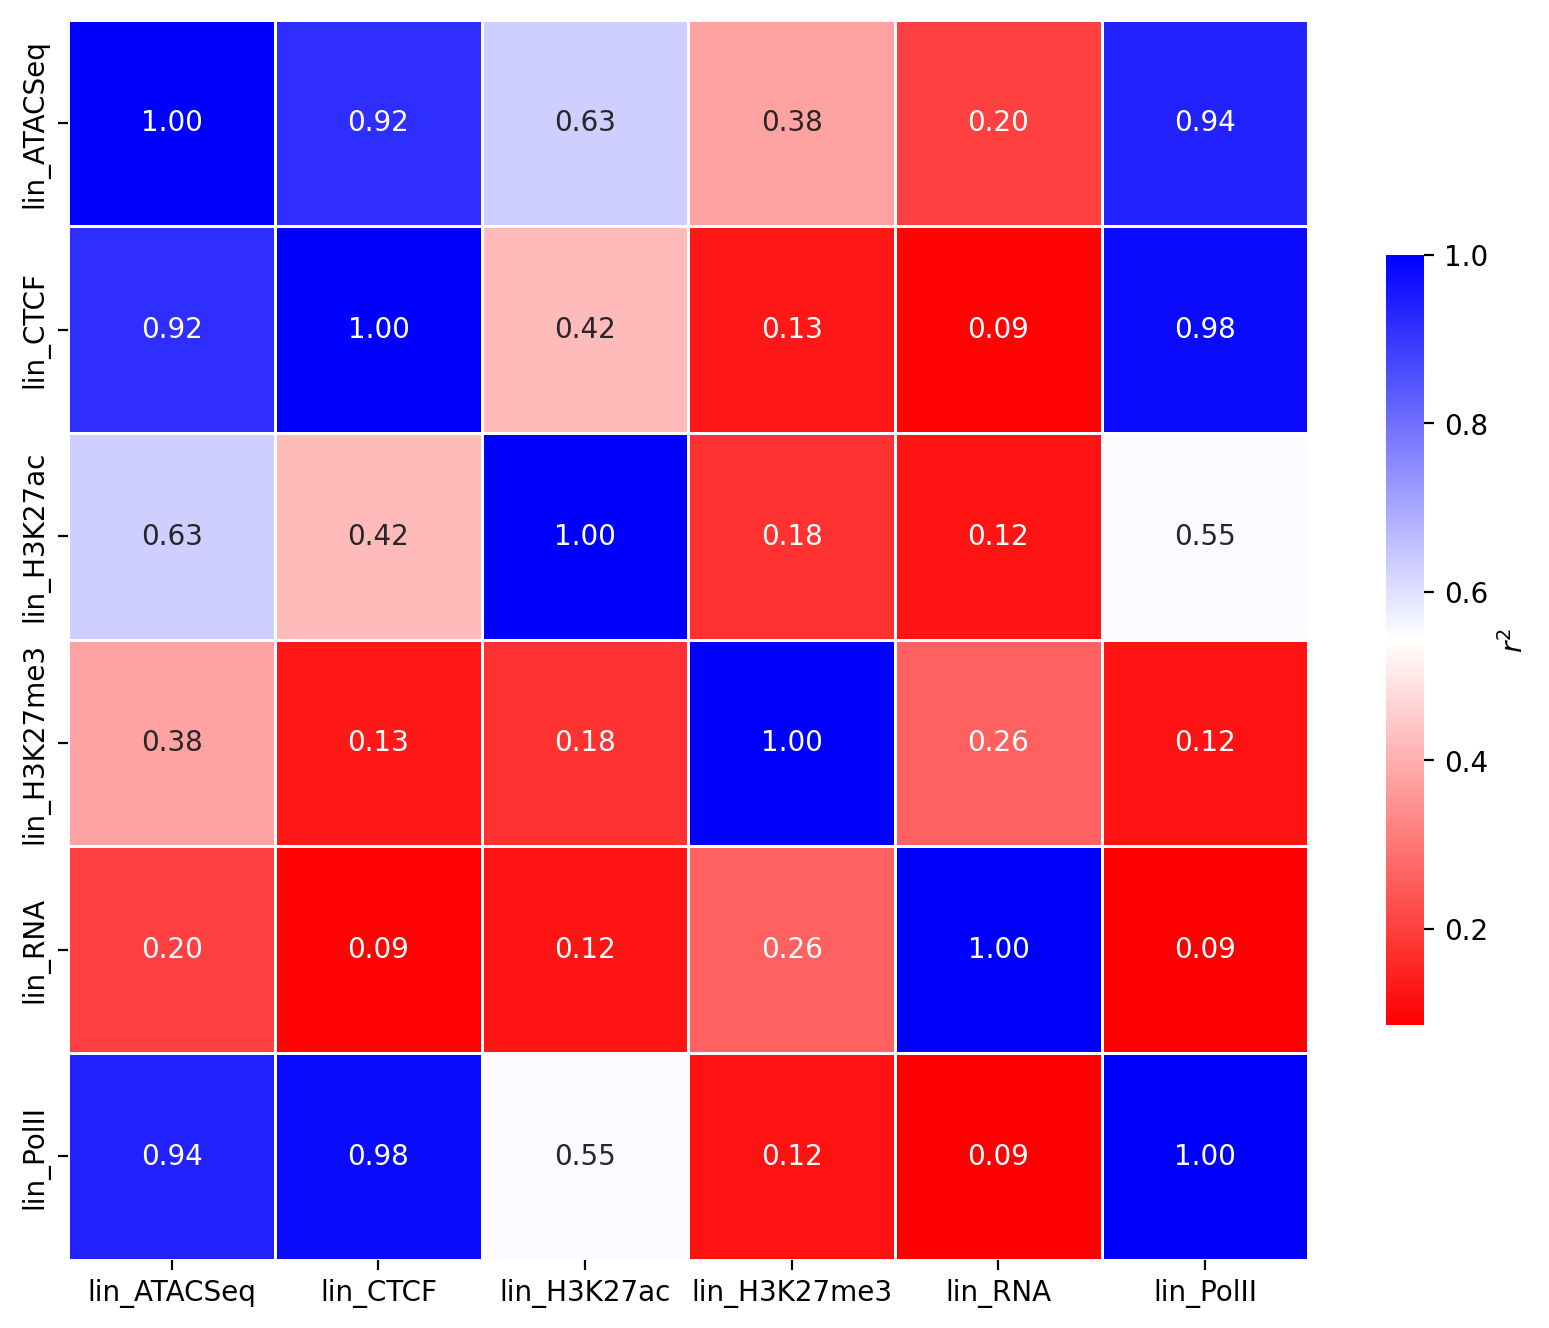

In [9]:
%%time
funcs = {
    'lin' : 'linear',  # nodes in higher-order hyperedges are more central 
    'le' : 'log-exp', # nodes in lower-order hyperedges are more central
}

ec_columns = []
total = len(funcs) * len(features)
count = 0

print(f"[INFO] Starting centrality computation for {total} (function × field) runs...")

for func_name, func in funcs.items():
    print(f"[INFO] Function = {func_name} ({func})")
    for field in features:
        count += 1
        column_name = f"{func_name}_{field}"
        ec_columns.append(column_name)

        print(f"  [{count}/{total}] Processing field: {field} -> {column_name}")
        node_ev, _ = central.hevc(
            H, function=func, 
            node_weights=ndf[field].to_numpy(),
        )
        ndf[column_name] = ut.min_max(node_ev)
    break

print("[DONE] All centrality columns added.")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10
sns.heatmap(
    ndf[ec_columns].corr(),
    square=True,
    cbar_kws={'shrink' : 0.5, 'label' : r'$r^2$'},
    lw=1,
    annot=True,
    fmt=".2f",                     # 2 decimals
    cmap='bwr_r',
)

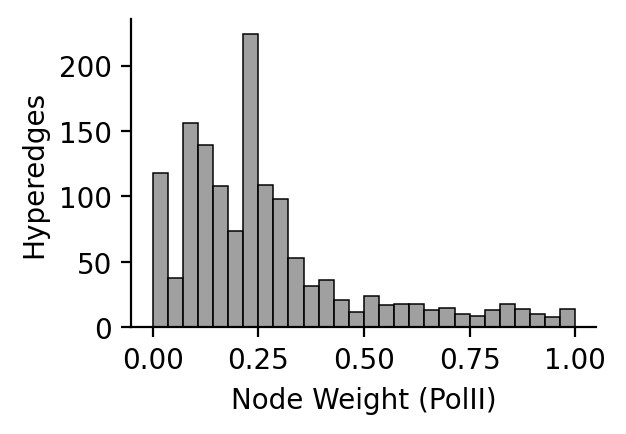

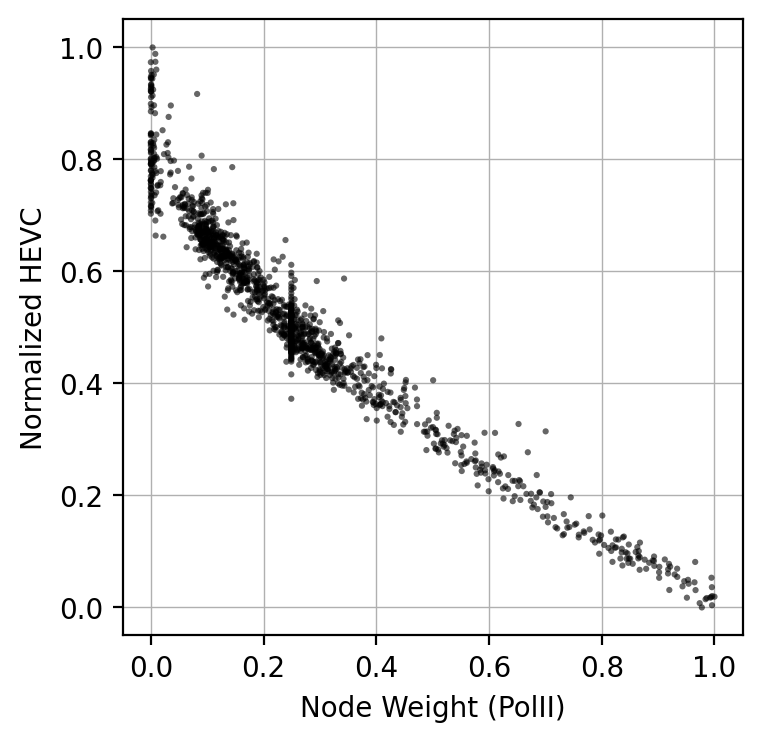

ATACSeq        -0.75
CTCF           -0.69
H3K27ac        -0.56
H3K27me3       -0.34
RNA            -0.38
PolII          -0.96
lin_ATACSeq    -0.17
lin_CTCF       -0.05
lin_H3K27ac    -0.09
lin_H3K27me3   -0.35
lin_RNA        -0.39
lin_PolII      -0.03
hevc            1.00
hevc_norm       1.00
CPU times: user 5.6 s, sys: 167 ms, total: 5.77 s
Wall time: 5.8 s


In [10]:
%%time

node_weight = 'PolII'
weights = ndf[node_weight].to_numpy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2
sns.histplot(
    weights,
    color='gray',
)
plt.ylabel('Hyperedges')
plt.xlabel(f'Node Weight ({node_weight})')
sns.despine()
plt.show()


node_ev, _ = central.hevc(
    H, 
    function='log-exp', # nodes in lower-order hyperedges are more central
    node_weights=weights,
)


ndf['hevc'] = list(node_ev)
ndf['hevc_norm'] = ut.min_max(node_ev)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# Scatter
sns.scatterplot(
    data=ndf,
    x=node_weight,
    y='hevc_norm',
    s=5, ec='none',
    alpha=0.6, c='k',
    zorder=10,
)

plt.grid(zorder=0, lw=0.5,)
# plt.xscale('log')
plt.xlabel(f'Node Weight ({node_weight})')
plt.ylabel('Normalized HEVC')
plt.show()

print(ndf.corr()['hevc_norm'].round(2).to_string())

## Centrality (of edges)!

In [35]:
B = H.copy()
print(f"{B.shape=}")

B.shape=(1419, 87215)


In [36]:
%%time
# HEVC
node_ev, edge_ev = central.hevc(B, function='linear')
print(f"{len(node_ev)=} {type(node_ev)=}")
print(f"{len(edge_ev)=} {type(edge_ev)=}")

len(node_ev)=1419 type(node_ev)=<class 'numpy.ndarray'>
len(edge_ev)=87215 type(edge_ev)=<class 'numpy.ndarray'>
CPU times: user 11.4 s, sys: 10.8 ms, total: 11.4 s
Wall time: 11.5 s


In [37]:
%%time
# HLRC
blist = ut.incidence_to_list_of_list(B)
hlrc = curv.compute_hlrc(blist)
print(f"{len(hlrc)=} {type(hlrc)=}")

len(hlrc)=87215 type(hlrc)=<class 'list'>
CPU times: user 4.44 s, sys: 41.7 ms, total: 4.48 s
Wall time: 4.5 s


In [38]:
%%time
# FRC
frc = curv.compute_forman_curvature(B)
print(f"{len(frc)=} {type(frc)=}")

len(frc)=87215 type(frc)=<class 'pandas.core.series.Series'>
CPU times: user 5min 20s, sys: 2.69 s, total: 5min 22s
Wall time: 5min 24s


In [39]:
%%time
df = pd.DataFrame({
    'hevc' : list(edge_ev),
    'hlrc' : list(hlrc),
    'frc' : list(frc),
})

print(f"{df.shape=}")
print(df.head().to_string())
print()

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
df[df.columns] = scaler.fit_transform(df[df.columns])
print(df.head().to_string())

df.shape=(87215, 3)
       hevc      hlrc     frc
0  0.000013 -0.832004 -1075.0
1  0.000005 -0.699144  -365.0
2  0.000005 -0.314512  -393.0
3  0.000004 -0.616873  -379.0
4  0.000022 -0.903011  -893.0

       hevc      hlrc       frc
0 -0.925385 -0.722720  0.257403
1 -0.980665 -0.478665  0.796507
2 -0.980040  0.227879  0.775247
3 -0.981755 -0.327539  0.785877
4 -0.875389 -0.853154  0.395596
CPU times: user 74.6 ms, sys: 8.98 ms, total: 83.6 ms
Wall time: 83.1 ms


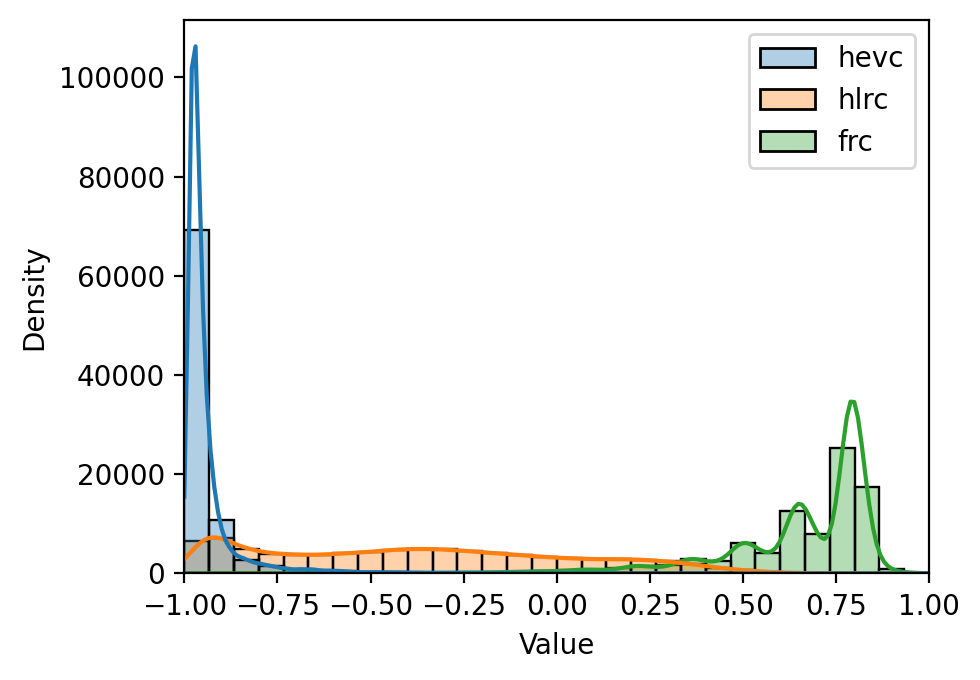

In [40]:

cols = ['hevc', 'hlrc', 'frc']
long = df[cols].melt(var_name='feature', value_name='value')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3.5
sns.histplot(
    data=long, x='value', hue='feature',
    bins=30, kde=True, common_bins=True,
    alpha=0.35,
)
plt.xlim(-1, 1)
plt.xlabel('Value')
plt.ylabel('Density')
sns.move_legend(
    plt.gca(),
    title="",
    loc='best',
)
plt.tight_layout()
plt.show()

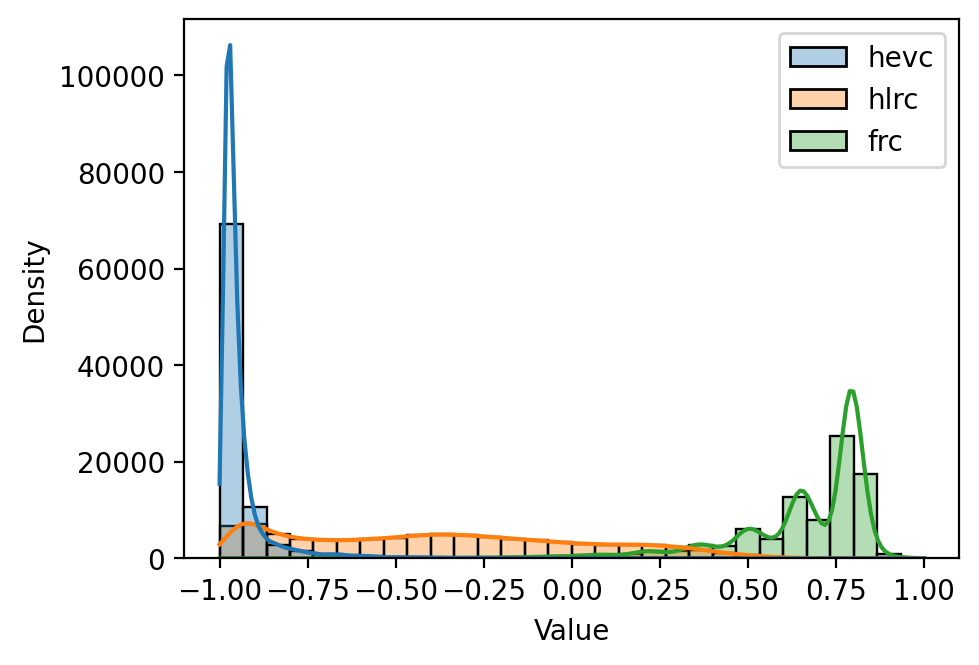

In [41]:

cols = ['hevc', 'hlrc', 'frc']
long = df[cols].melt(var_name='feature', value_name='value')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3.5
sns.histplot(
    data=long, x='value', hue='feature',
    bins=30, kde=True, common_bins=True,
    alpha=0.35,
)
plt.xlim(-1, 1)
plt.xlabel('Value')
plt.ylabel('Density')
sns.move_legend(
    plt.gca(),
    title="",
    loc='best',
)
plt.xlim([-1.1, 1.1])
plt.show()

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'hevc'), Text(0, 1.5, 'hlrc'), Text(0, 2.5, 'frc')])

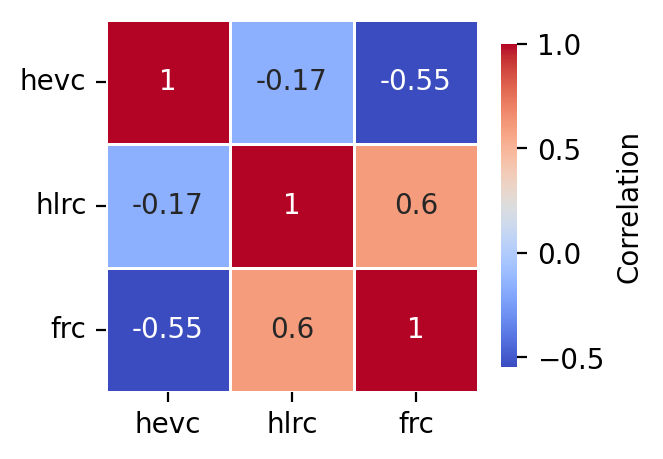

In [17]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sns.heatmap(
    df.corr(),
    square=True,
    lw=1,
    cbar_kws={'shrink' : 0.7, 'label' : 'Correlation'},
    annot=True,
    cmap='coolwarm'
)

plt.yticks(rotation=0)

In [18]:
%%time

print(f"{H.shape=}")

node_ev, edge_ev = central.hevc(
    H, 
    function='log-exp', 
    maxiter=10000,
)

df = pd.DataFrame({
    'read_name' : H.columns,
    'hevc' : list(edge_ev),
    'hevc_norm': ut.min_max(edge_ev),  # Assuming you have ut.min_max elsewhere
})

df.head()

H.shape=(1419, 87215)
CPU times: user 5.65 s, sys: 208 ms, total: 5.85 s
Wall time: 5.89 s


read_name          hevc     hevc_norm
0  9052b9ea-478f-4351-bc31-6a0a3f9becb5  5.406200e-18  2.084165e-13
1  a7d58484-4b6f-4498-960b-71d8229b3d94  2.183761e-05  8.418702e-01
2  d069851e-2ad6-4ac4-9df1-6a09921b3b7e  2.218966e-05  8.554423e-01
3  ca19a9ca-93bd-4c37-863e-7ec6768a12aa  2.263896e-05  8.727633e-01
4  7bd11f1d-e455-43ff-8f2a-885d6caa5783  8.500613e-15  3.277105e-10

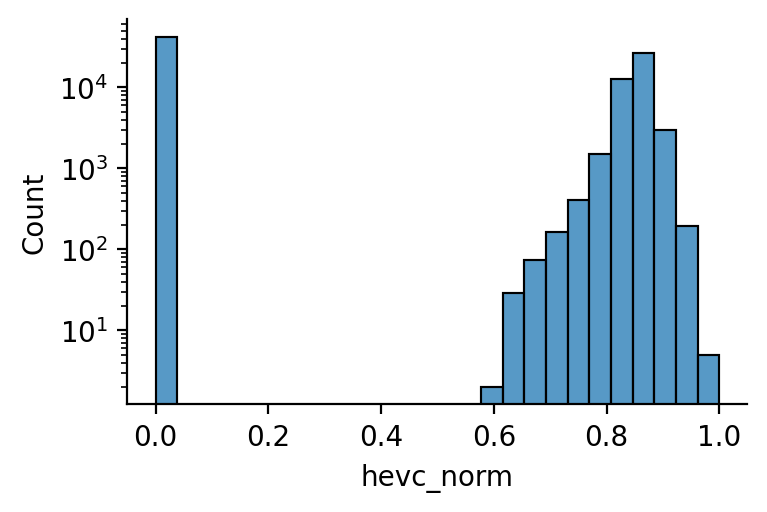

In [19]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5

sns.histplot(
    data=df,
    x='hevc_norm',
)

plt.yscale('log')
sns.despine()

## Curvaciousness

len(Hlist)=87215
len(hlrc)=87215
CPU times: user 4.73 s, sys: 54.7 ms, total: 4.78 s
Wall time: 4.81 s


read_name          hevc     hevc_norm      hlrc  \
0  9052b9ea-478f-4351-bc31-6a0a3f9becb5  5.406200e-18  2.084165e-13 -0.832004   
1  a7d58484-4b6f-4498-960b-71d8229b3d94  2.183761e-05  8.418702e-01 -0.699144   
2  d069851e-2ad6-4ac4-9df1-6a09921b3b7e  2.218966e-05  8.554423e-01 -0.314512   
3  ca19a9ca-93bd-4c37-863e-7ec6768a12aa  2.263896e-05  8.727633e-01 -0.616873   
4  7bd11f1d-e455-43ff-8f2a-885d6caa5783  8.500613e-15  3.277105e-10 -0.903011   

   hlrc_norm  
0   0.138640  
1   0.260667  
2   0.613940  
3   0.336231  
4   0.073423

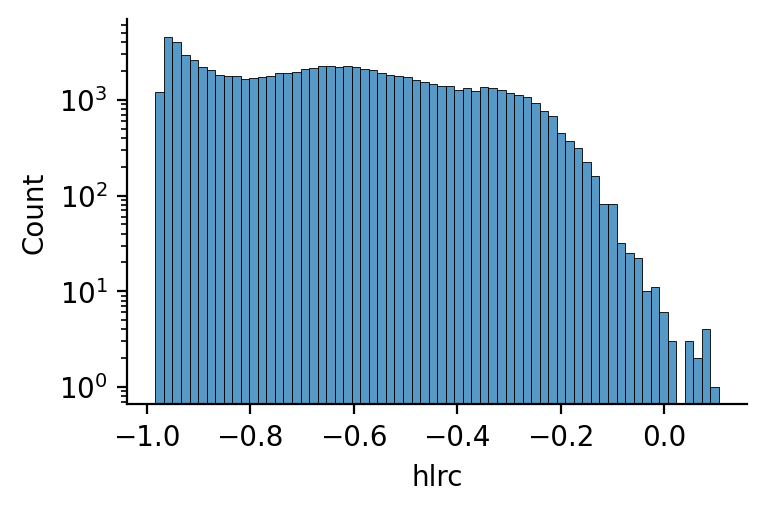

In [20]:
%%time

Hlist = ut.incidence_to_list_of_list(H)
print(f"{len(Hlist)=}")

hlrc = curv.compute_hlrc(Hlist)
print(f"{len(hlrc)=}")

# add edge curvature to dataframe
df['hlrc'] = hlrc
df['hlrc_norm'] = ut.min_max(df['hlrc'])


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5

sns.histplot(
    data=df,
    x='hlrc',
)


plt.yscale('log')
sns.despine()

df.head()

In [21]:
pdf = pd.merge(
    df, adata.var,
    how='left',
    right_index=True,
    left_on='read_name',
)

pdf.head()

read_name          hevc     hevc_norm      hlrc  \
0  9052b9ea-478f-4351-bc31-6a0a3f9becb5  5.406200e-18  2.084165e-13 -0.832004   
1  a7d58484-4b6f-4498-960b-71d8229b3d94  2.183761e-05  8.418702e-01 -0.699144   
2  d069851e-2ad6-4ac4-9df1-6a09921b3b7e  2.218966e-05  8.554423e-01 -0.314512   
3  ca19a9ca-93bd-4c37-863e-7ec6768a12aa  2.263896e-05  8.727633e-01 -0.616873   
4  7bd11f1d-e455-43ff-8f2a-885d6caa5783  8.500613e-15  3.277105e-10 -0.903011   

   hlrc_norm  read_index basename  mean_mapq  median_mapq  n_chromosomes  \
0   0.138640          30  batch04  53.368421         60.0              3   
1   0.260667          93  batch04  53.500000         60.0              3   
2   0.613940         142  batch04  40.666667         60.0              4   
3   0.336231         199  batch03  48.814815         60.0              8   
4   0.073423         203  batch01  60.000000         60.0              2   

   order  n_bins  read_length_bp  \
0     19       8            9678   
1      4       4            4215   
2      9       6            5346   
3     27      16           12241   
4      8       6            6061   

                                               genes  n_genes  chrom_order  
0                                       Chl1;Tmem135        2            6  
1                                     Gm49685;Shank2        2            2  
2                                    Pigx;Eef2k;Sox6        3            2  
3  C030029H02Rik;Lrriq4;Luc7l2;Pik3ca;Lrrc31;Psma...        7            2  
4                               Or2bd2;Ppp6r1;Cacng8        3            5

low_curv.shape=(9, 16)


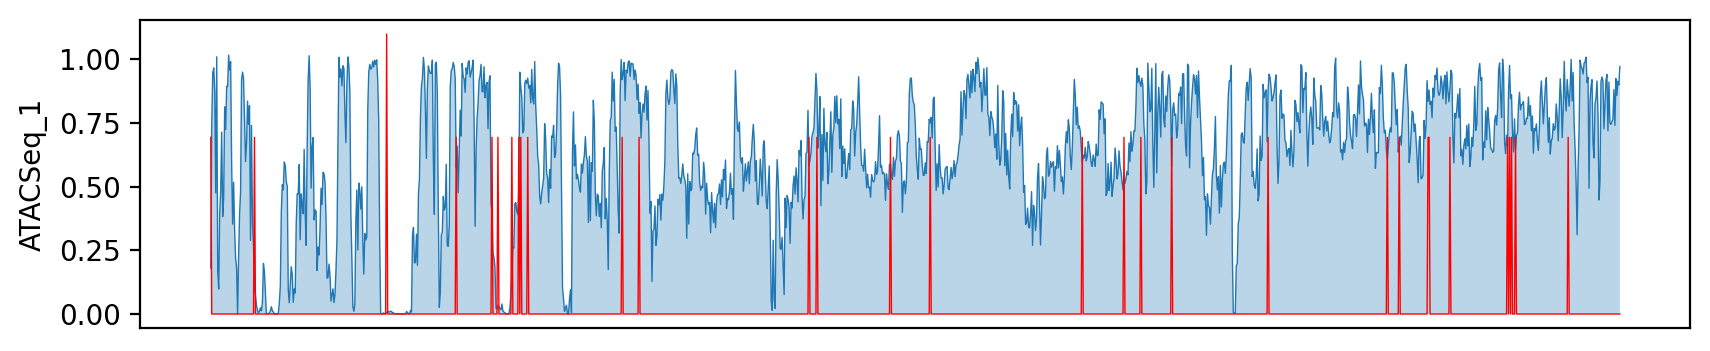

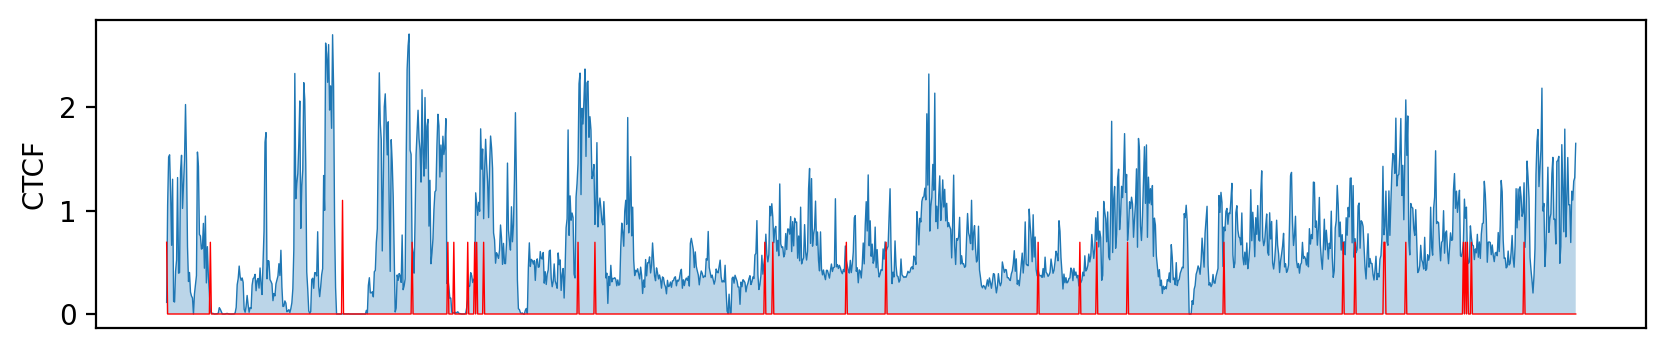

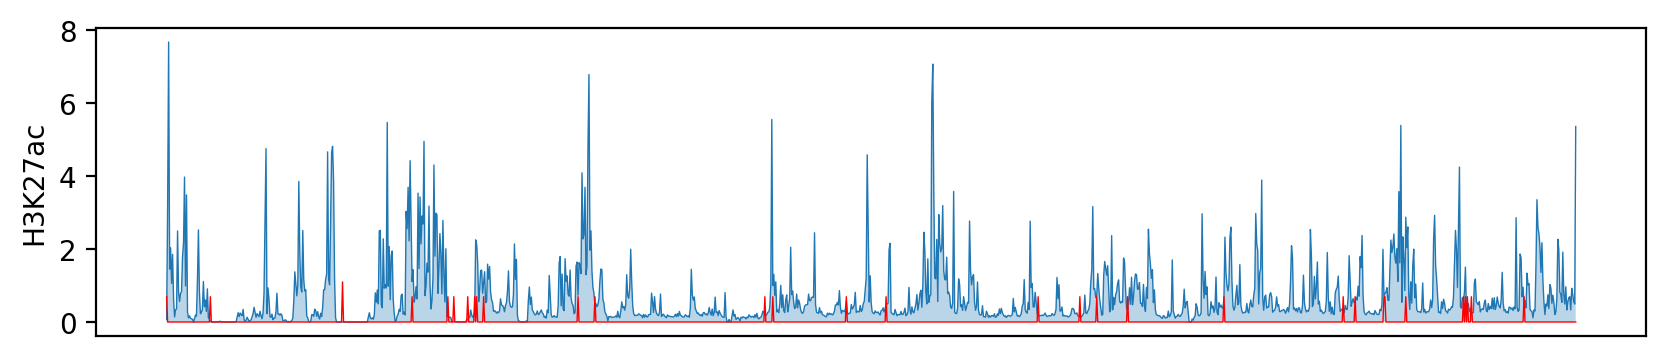

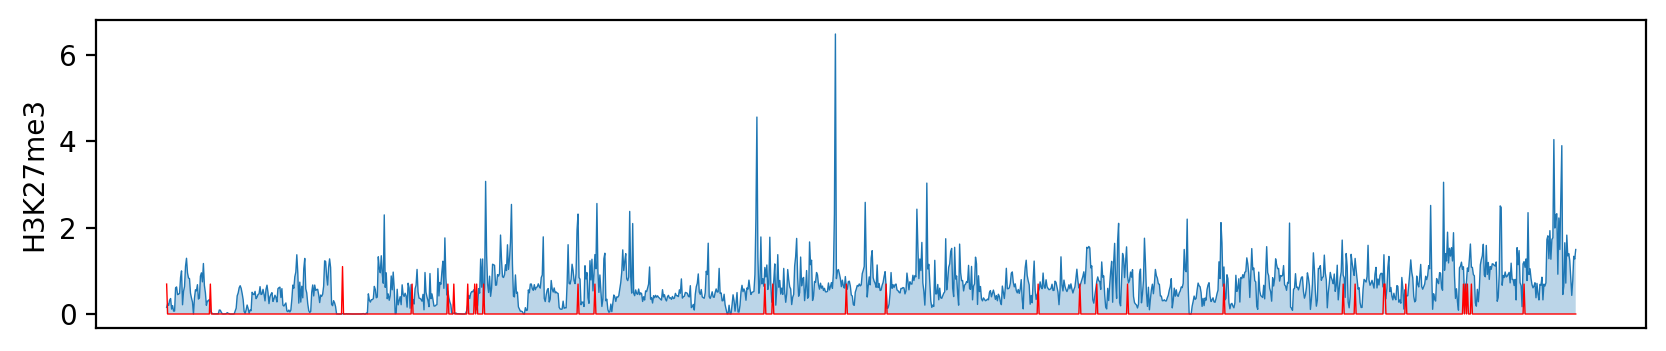

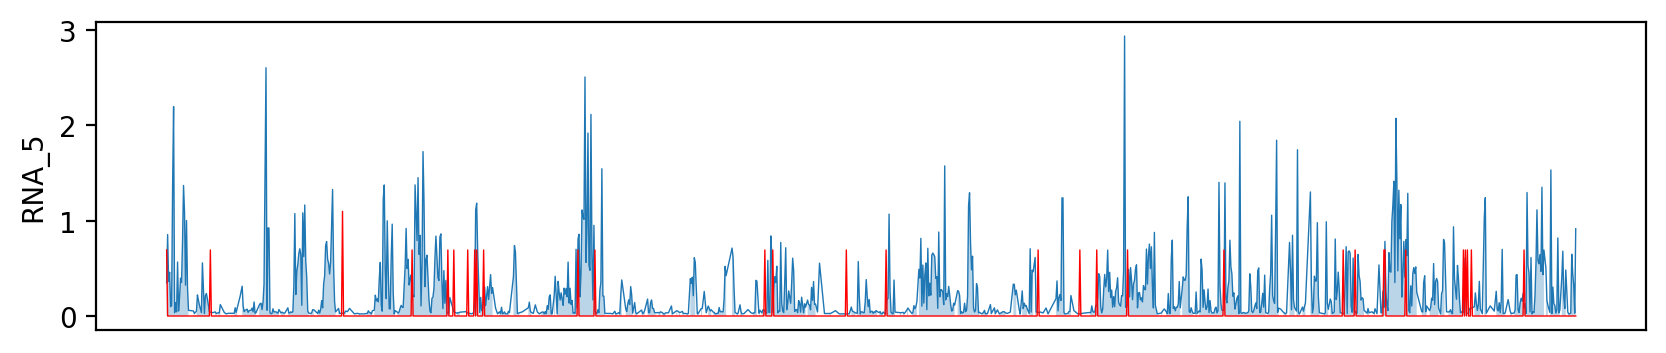

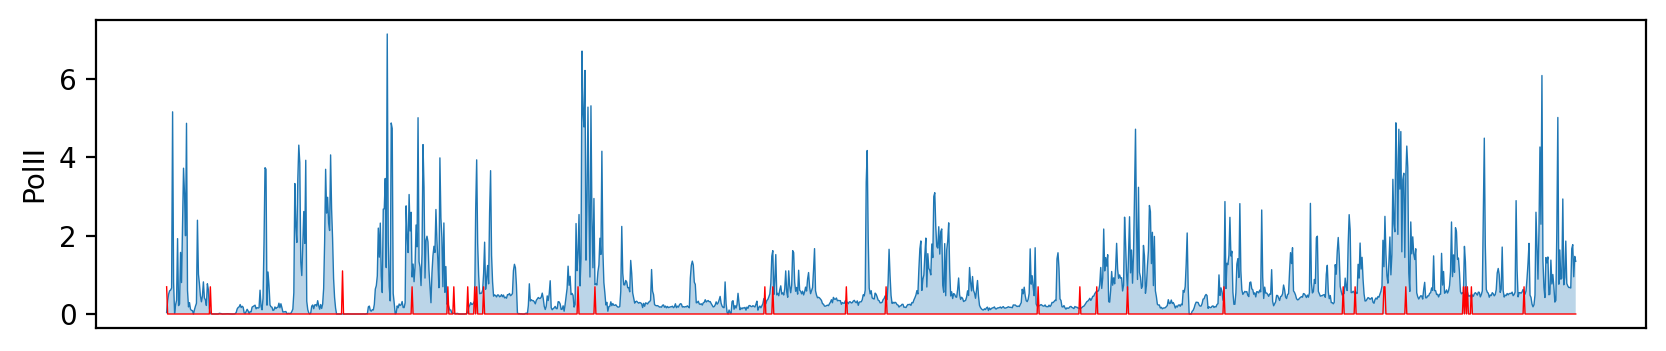

In [22]:
q = 0.01

low_curv = pdf[pdf['hlrc'] < np.percentile(pdf['hlrc'], q)]
print(f"{low_curv.shape=}")

Hhat = adata[:, low_curv['read_name']].to_df().sum(axis=1).reset_index().reset_index()
Hhat.columns = ['index', 'bin_name', 'low_curv_degree']
Hhat['low_curv_degree_log'] = np.log1p(Hhat['low_curv_degree'])
Hhat = pd.concat([Hhat, adata.obs.reset_index().copy()], axis=1)
Hhat['RNA_5'] = np.log1p(Hhat['RNA_5'])
Hhat['index'] = Hhat['index'].astype(int)

columns = [
    'ATACSeq_1',
    # 'ATACSeq_2',
    # 'ATACSeq_3',
    'CTCF',
    'H3K27ac',
    'H3K27me3',
    # 'RNA_1', 
    # 'RNA_2', 
    # 'RNA_3', 
    # 'RNA_4',
    'RNA_5',
    # 'RNA_6', 
    'PolII',
]

for k in columns:

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 10, 2
    x, y = Hhat['index'], Hhat[k]
    sns.lineplot(x=x, y=y, lw=0.5)
    plt.fill_between(x, y, 0, alpha=0.3)

    y2 = Hhat['low_curv_degree_log']
    sns.lineplot(x=x, y=y2, lw=0.5, c='r')
    
    plt.xticks([])
    plt.xlabel("")
    # plt.title(k)
    plt.show()

low_curv.shape=(86351, 16)


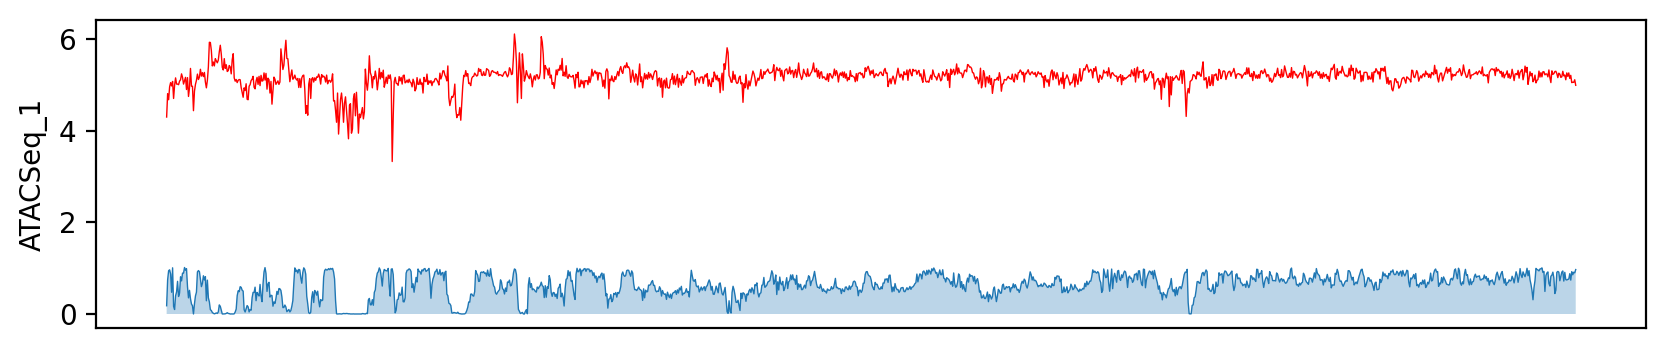

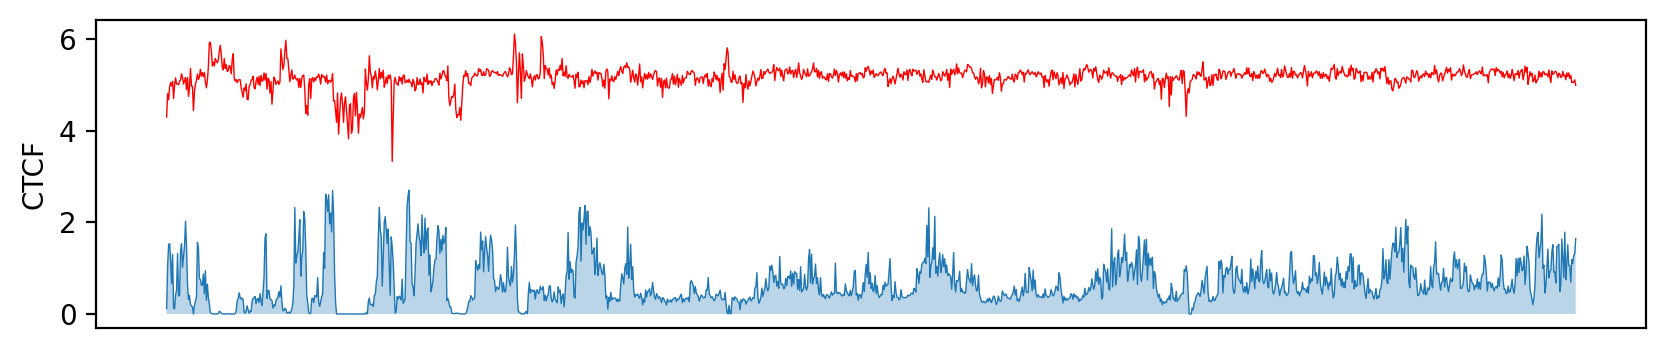

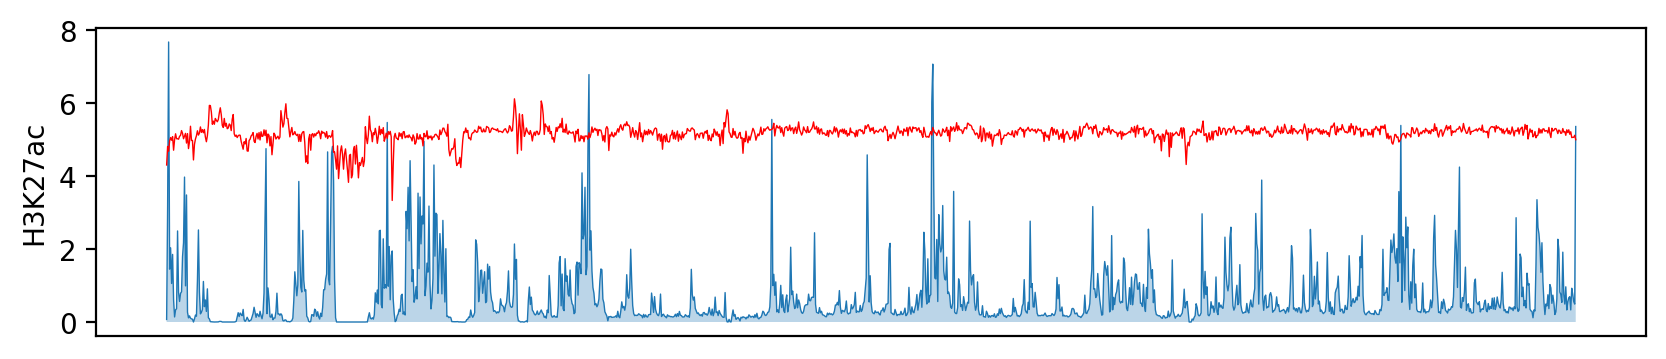

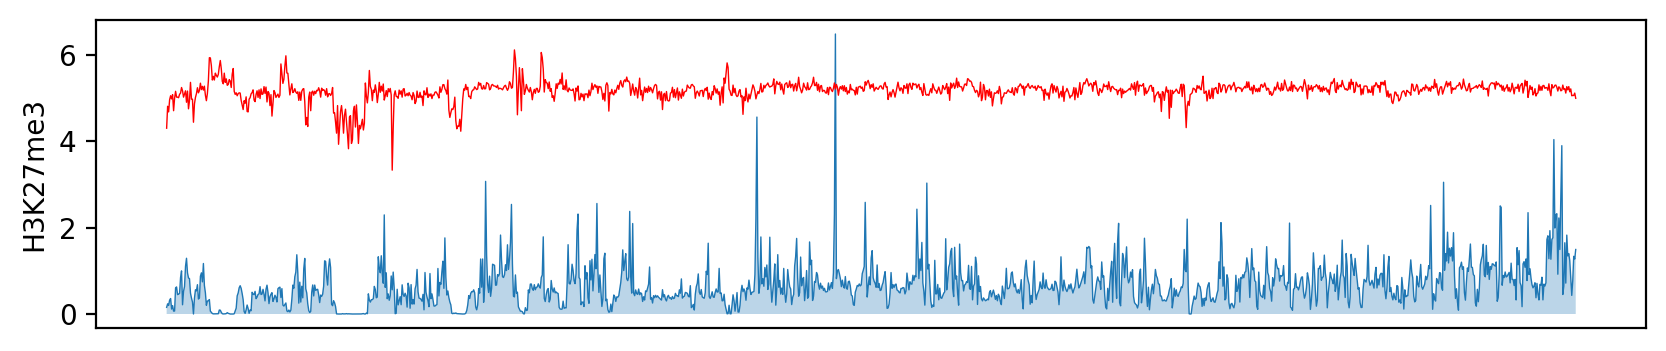

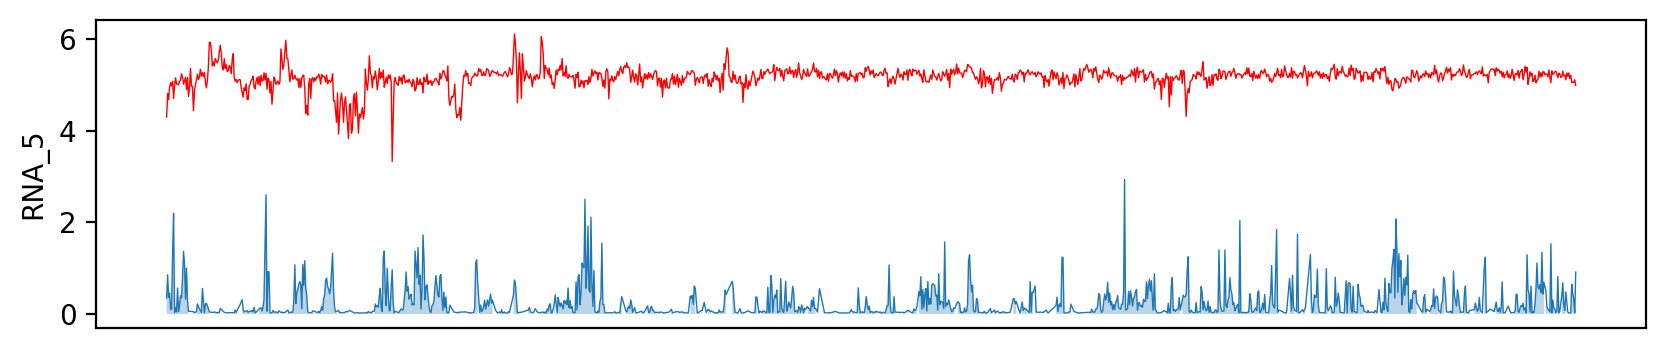

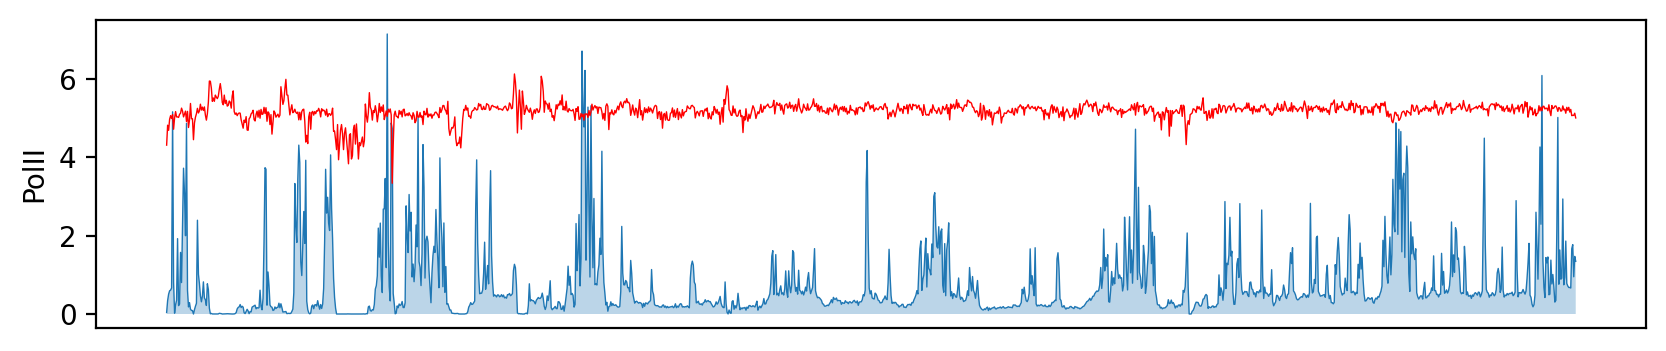

In [23]:
q = 0.99

low_curv = pdf[pdf['hlrc'] > np.percentile(pdf['hlrc'], q)]
print(f"{low_curv.shape=}")

Hhat = adata[:, low_curv['read_name']].to_df().sum(axis=1).reset_index().reset_index()
Hhat.columns = ['index', 'bin_name', 'low_curv_degree']
Hhat['low_curv_degree_log'] = np.log1p(Hhat['low_curv_degree'])
Hhat = pd.concat([Hhat, adata.obs.reset_index().copy()], axis=1)
Hhat['RNA_5'] = np.log1p(Hhat['RNA_5'])
Hhat['index'] = Hhat['index'].astype(int)

columns = [
    'ATACSeq_1',
    # 'ATACSeq_2',
    # 'ATACSeq_3',
    'CTCF',
    'H3K27ac',
    'H3K27me3',
    # 'RNA_1', 
    # 'RNA_2', 
    # 'RNA_3', 
    # 'RNA_4',
    'RNA_5',
    # 'RNA_6', 
    'PolII',
]

for k in columns:

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 10, 2
    x, y = Hhat['index'], Hhat[k]
    sns.lineplot(x=x, y=y, lw=0.5)
    plt.fill_between(x, y, 0, alpha=0.3)

    y2 = Hhat['low_curv_degree_log']
    sns.lineplot(x=x, y=y2, lw=0.5, c='r')
    
    plt.xticks([])
    plt.xlabel("")
    # plt.title(k)
    plt.show()

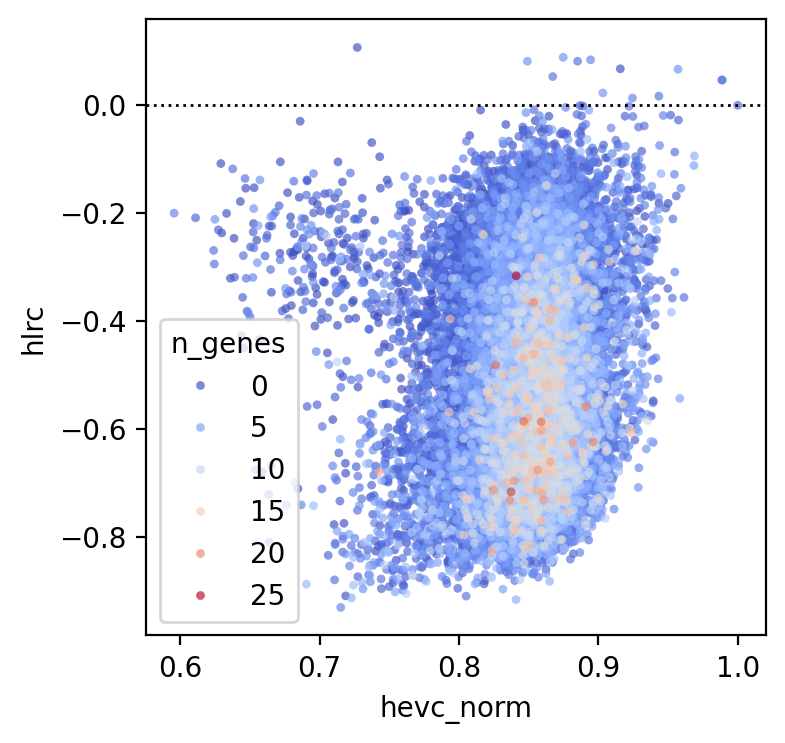

In [24]:
hevc_threshold = 0.01
plot_df = pdf[pdf['hevc_norm'] > hevc_threshold].copy()
plot_df = plot_df.sort_values('n_genes')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=plot_df,
    x='hevc_norm',
    y='hlrc',
    ec='none',
    s=10,
    alpha=0.65,
    hue='n_genes',
    palette='coolwarm',
)

plt.axhline(y=0, lw=1, c='k', ls=":")

## Featuring - on average

In [26]:
adata.obs.columns

Index(['bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin',
       'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
       'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4',
       'RNA_5', 'RNA_6', 'PolII', 'chrom_degree'],
      dtype='object')

In [27]:
%%time

columns = [
    'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
    'CTCF', 'H3K27ac', 'H3K27me3',
    'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6',
    'PolII'
]

# Ensure dense array for indexing
X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X

# Result dict: var_name -> mean obs values
result = {}
for i, var_name in tqdm(enumerate(adata.var_names), total=10, desc="Computing means"):
    mask = X[:, i] == 1
    if mask.sum() > 0:
        result[var_name] = adata.obs[columns].loc[mask].mean(numeric_only=True)

# Convert to DataFrame
df_means = pd.DataFrame(result).T
df_means

Computing means: 100067it [01:14, 1338.19it/s]         


CPU times: user 1min 16s, sys: 1.68 s, total: 1min 18s
Wall time: 1min 19s


ATACSeq_1  ATACSeq_2  ATACSeq_3  \
9052b9ea-478f-4351-bc31-6a0a3f9becb5   0.570718   0.332500   0.451762   
a7d58484-4b6f-4498-960b-71d8229b3d94   0.620177   0.535097   0.574142   
d069851e-2ad6-4ac4-9df1-6a09921b3b7e   0.694394   0.416619   0.535605   
ca19a9ca-93bd-4c37-863e-7ec6768a12aa   0.779747   0.645501   0.703526   
7bd11f1d-e455-43ff-8f2a-885d6caa5783   0.704287   0.677532   0.649029   
...                                         ...        ...        ...   
86404c84-f39d-421a-a38f-941375f49c73   0.802335   0.872549   0.844965   
8dea8764-6c54-4e35-b868-a8ec1826a118   0.025116   0.007670   0.015411   
b4ec0bbf-b10d-4b8c-9fe3-9a480d14d006   0.635520   0.576309   0.599886   
999ffa42-a4e8-495c-87e1-91a22551e726   0.731289   0.716099   0.713673   
ead1e6f3-4342-45dd-9af6-6206887052e1   0.677540   0.564644   0.597119   

                                          CTCF   H3K27ac  H3K27me3     RNA_1  \
9052b9ea-478f-4351-bc31-6a0a3f9becb5  0.386447  0.255191  0.759144  0.132095   
a7d58484-4b6f-4498-960b-71d8229b3d94  0.576824  0.622391  0.658047  0.225174   
d069851e-2ad6-4ac4-9df1-6a09921b3b7e  0.434102  0.250207  0.796111  0.207139   
ca19a9ca-93bd-4c37-863e-7ec6768a12aa  0.711379  0.684734  0.924108  0.166332   
7bd11f1d-e455-43ff-8f2a-885d6caa5783  0.803807  0.929803  0.600753  0.152006   
...                                        ...       ...       ...       ...   
86404c84-f39d-421a-a38f-941375f49c73  0.872203  1.100481  0.454481  0.166029   
8dea8764-6c54-4e35-b868-a8ec1826a118  0.005231  0.001611  0.005318       NaN   
b4ec0bbf-b10d-4b8c-9fe3-9a480d14d006  1.037678  0.759162  0.860714  0.139369   
999ffa42-a4e8-495c-87e1-91a22551e726  1.101323  0.378336  1.234245  0.128379   
ead1e6f3-4342-45dd-9af6-6206887052e1  0.572468  0.363272  1.156425  0.111940   

                                         RNA_2     RNA_3     RNA_4     RNA_5  \
9052b9ea-478f-4351-bc31-6a0a3f9becb5  0.227282  0.161008  0.096405  0.153145   
a7d58484-4b6f-4498-960b-71d8229b3d94  0.624701  0.150976  0.161928  0.620273   
d069851e-2ad6-4ac4-9df1-6a09921b3b7e  0.040277  0.111940  0.083656  0.054539   
ca19a9ca-93bd-4c37-863e-7ec6768a12aa  0.660470  0.113362  0.168535  0.323504   
7bd11f1d-e455-43ff-8f2a-885d6caa5783  0.448464  0.145340  0.112839  0.375706   
...                                        ...       ...       ...       ...   
86404c84-f39d-421a-a38f-941375f49c73  0.845660  0.228794  0.111693  1.662336   
8dea8764-6c54-4e35-b868-a8ec1826a118  0.083858  0.129952  0.076647  0.035407   
b4ec0bbf-b10d-4b8c-9fe3-9a480d14d006  0.102304  0.125576  0.108856  0.120379   
999ffa42-a4e8-495c-87e1-91a22551e726  0.095975  0.192005  0.094993  0.121571   
ead1e6f3-4342-45dd-9af6-6206887052e1       NaN       NaN  0.075030  0.044740   

                                         RNA_6     PolII  
9052b9ea-478f-4351-bc31-6a0a3f9becb5  0.082437  0.190472  
a7d58484-4b6f-4498-960b-71d8229b3d94  0.103642  1.065517  
d069851e-2ad6-4ac4-9df1-6a09921b3b7e       NaN  0.351755  
ca19a9ca-93bd-4c37-863e-7ec6768a12aa  0.140503  0.800107  
7bd11f1d-e455-43ff-8f2a-885d6caa5783  0.111773  0.842917  
...                                        ...       ...  
86404c84-f39d-421a-a38f-941375f49c73  0.196497  1.483784  
8dea8764-6c54-4e35-b868-a8ec1826a118  0.075030  0.001441  
b4ec0bbf-b10d-4b8c-9fe3-9a480d14d006  0.087437  0.364439  
999ffa42-a4e8-495c-87e1-91a22551e726  0.104195  0.715077  
ead1e6f3-4342-45dd-9af6-6206887052e1       NaN  0.505622  

[100067 rows x 13 columns]

In [28]:
%%time
kdf = pd.merge(
    pdf, df_means,
    how='left',
    right_index=True,
    left_on='read_name',
)

kdf.head()

CPU times: user 82.4 ms, sys: 15.8 ms, total: 98.2 ms
Wall time: 97.6 ms


read_name          hevc     hevc_norm      hlrc  \
0  9052b9ea-478f-4351-bc31-6a0a3f9becb5  5.406200e-18  2.084165e-13 -0.832004   
1  a7d58484-4b6f-4498-960b-71d8229b3d94  2.183761e-05  8.418702e-01 -0.699144   
2  d069851e-2ad6-4ac4-9df1-6a09921b3b7e  2.218966e-05  8.554423e-01 -0.314512   
3  ca19a9ca-93bd-4c37-863e-7ec6768a12aa  2.263896e-05  8.727633e-01 -0.616873   
4  7bd11f1d-e455-43ff-8f2a-885d6caa5783  8.500613e-15  3.277105e-10 -0.903011   

   hlrc_norm  read_index basename  mean_mapq  median_mapq  n_chromosomes  ...  \
0   0.138640          30  batch04  53.368421         60.0              3  ...   
1   0.260667          93  batch04  53.500000         60.0              3  ...   
2   0.613940         142  batch04  40.666667         60.0              4  ...   
3   0.336231         199  batch03  48.814815         60.0              8  ...   
4   0.073423         203  batch01  60.000000         60.0              2  ...   

       CTCF   H3K27ac  H3K27me3     RNA_1     RNA_2     RNA_3     RNA_4  \
0  0.386447  0.255191  0.759144  0.132095  0.227282  0.161008  0.096405   
1  0.576824  0.622391  0.658047  0.225174  0.624701  0.150976  0.161928   
2  0.434102  0.250207  0.796111  0.207139  0.040277  0.111940  0.083656   
3  0.711379  0.684734  0.924108  0.166332  0.660470  0.113362  0.168535   
4  0.803807  0.929803  0.600753  0.152006  0.448464  0.145340  0.112839   

      RNA_5     RNA_6     PolII  
0  0.153145  0.082437  0.190472  
1  0.620273  0.103642  1.065517  
2  0.054539       NaN  0.351755  
3  0.323504  0.140503  0.800107  
4  0.375706  0.111773  0.842917  

[5 rows x 29 columns]

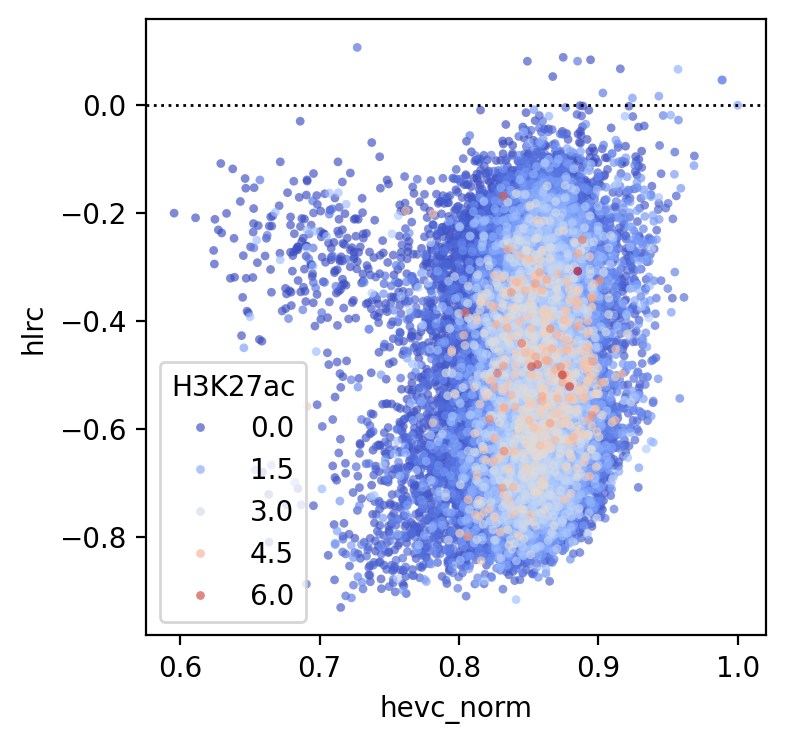

In [29]:
color_by = 'H3K27ac'
hevc_threshold = 0.01
plot_df = kdf[kdf['hevc_norm'] > hevc_threshold].copy()
plot_df = plot_df.sort_values(color_by)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=plot_df,
    x='hevc_norm',
    y='hlrc',
    ec='none',
    s=10,
    alpha=0.65,
    hue=color_by,
    palette='coolwarm',
)

plt.axhline(y=0, lw=1, c='k', ls=":")

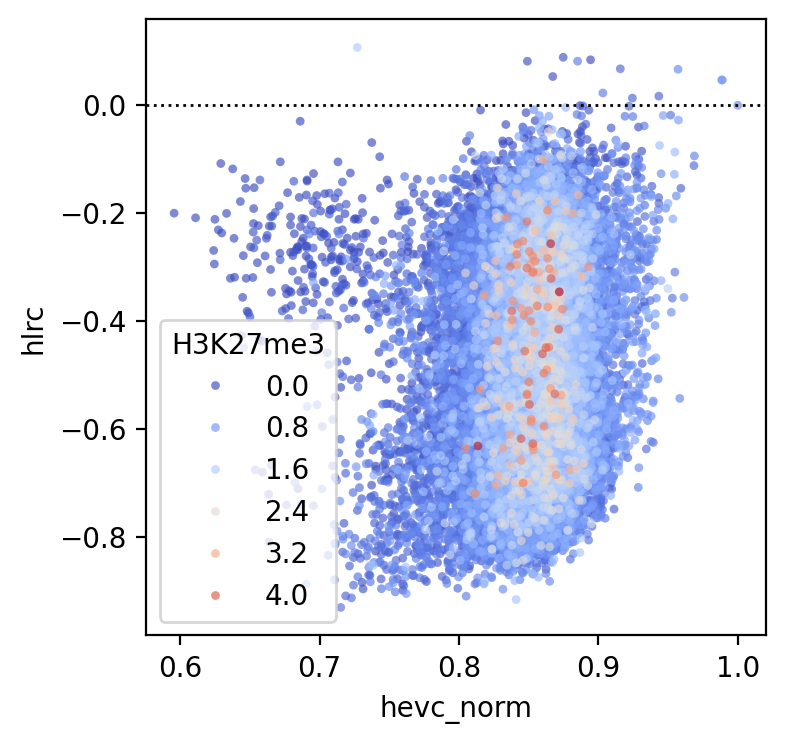

In [30]:
color_by = 'H3K27me3'
hevc_threshold = 0.01
plot_df = kdf[kdf['hevc_norm'] > hevc_threshold].copy()
plot_df = plot_df.sort_values(color_by)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=plot_df,
    x='hevc_norm',
    y='hlrc',
    ec='none',
    s=10,
    alpha=0.65,
    hue=color_by,
    palette='coolwarm',
)

plt.axhline(y=0, lw=1, c='k', ls=":")

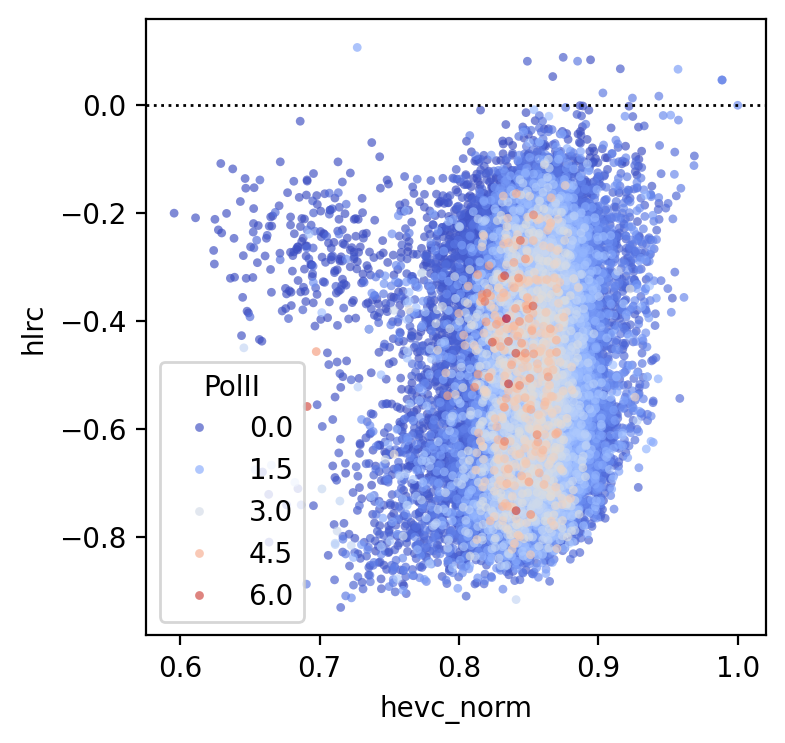

In [31]:
color_by = 'PolII'
hevc_threshold = 0.01
plot_df = kdf[kdf['hevc_norm'] > hevc_threshold].copy()
plot_df = plot_df.sort_values(color_by)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=plot_df,
    x='hevc_norm',
    y='hlrc',
    ec='none',
    s=10,
    alpha=0.65,
    hue=color_by,
    palette='coolwarm',
)

plt.axhline(y=0, lw=1, c='k', ls=":")

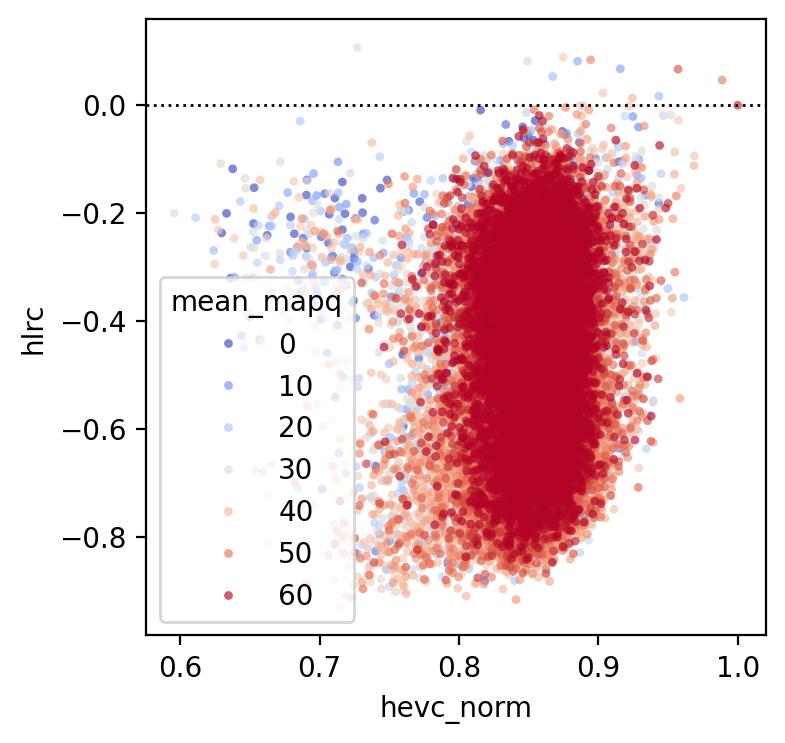

In [32]:
color_by = 'mean_mapq'
hevc_threshold = 0.01
plot_df = kdf[kdf['hevc_norm'] > hevc_threshold].copy()
plot_df = plot_df.sort_values(color_by)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=plot_df,
    x='hevc_norm',
    y='hlrc',
    ec='none',
    s=10,
    alpha=0.65,
    hue=color_by,
    palette='coolwarm',
)

plt.axhline(y=0, lw=1, c='k', ls=":")

In [33]:
sns.scatterplot(
    data=df, 
    x='ev',
    y='hlrc',
    s=1,
    ec='none',
)

ValueError: Could not interpret value `ev` for `x`. An entry with this name does not appear in `data`.